# NYC Taxi Trips

This is an Exploratory Data Analysis about the NYC taxi trips from 2009 to 2012. 

Through the data analysis presented we will first study and visualize the data, create new features and clean the data analyzing abnormal values. Then we apply a machine learning model trying to predict the fare amount of taxi ride based on the pickup and dropoff locations.

## Importing packages for analysis

Firstly we import all needed libraries and set some global settings for better visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid");

## Dataset

Now, we import the dataset from the files and merge them into a unique pandas DataFrame to simplify the analysis.

In [3]:
df_2009 = pd.read_json('data/data-sample_data-nyctaxi-trips-2009-json_corrigido.json', lines=True)
df_2010 = pd.read_json('data/data-sample_data-nyctaxi-trips-2010-json_corrigido.json', lines=True)
df_2011 = pd.read_json('data/data-sample_data-nyctaxi-trips-2011-json_corrigido.json', lines=True)
df_2012 = pd.read_json('data/data-sample_data-nyctaxi-trips-2012-json_corrigido.json', lines=True)

In [4]:
df_trips = pd.concat([df_2009, df_2010, df_2011, df_2012])

In [5]:
df_vendor = pd.read_csv('data/data-vendor_lookup-csv.csv')
df_payment = pd.read_csv('data/data-payment_lookup-csv.csv', skiprows=1)

We can look at the first lines of each DataFrame to have an idea of the data.

In [6]:
df_trips.head()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,payment_type,pickup_datetime,pickup_latitude,pickup_longitude,rate_code,store_and_fwd_flag,surcharge,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id
0,2009-04-21T18:57:09.433767+00:00,40.747950,-73.994712,5.4,2,Cash,2009-04-21T18:51:11.767205+00:00,40.742950,-74.004114,NaN,NaN,0.0,0.0,0.0,5.4,0.80,CMT
1,2009-01-13T07:50:36.386011+00:00,40.792385,-73.940449,15.4,1,Cash,2009-01-13T07:40:07.639754+00:00,40.747784,-73.996506,NaN,NaN,0.0,0.0,0.0,15.4,5.40,CMT
2,2009-01-06T19:43:09.908429+00:00,40.768108,-73.944535,6.1,5,CASH,2009-01-06T19:30:44.142187+00:00,40.752070,-73.951340,NaN,NaN,1.0,0.0,0.0,7.1,1.67,VTS
3,2009-09-24T08:41:56.739991+00:00,40.721812,-73.958122,12.9,1,CASH,2009-09-24T08:28:09.004451+00:00,40.729128,-74.001117,NaN,NaN,0.5,0.0,0.0,13.4,4.13,VTS
4,2009-10-29T05:57:22.880174+00:00,40.776075,-73.979757,7.7,1,CASH,2009-10-29T05:50:39.214629+00:00,40.756873,-73.976600,NaN,NaN,0.5,0.0,0.0,8.2,2.03,VTS


In [7]:
df_vendor.head()

,vendor_id,name,address,city,state,zip,country,contact,current
0,CMT,"Creative Mobile Technologies, LLC",950 4th Road Suite 78,Brooklyn,NY,11210,USA,contactCMT@gmail.com,Yes
1,VTS,VeriFone Inc,26 Summit St.,Flushing,NY,11354,USA,admin@vtstaxi.com,Yes
2,DDS,"Dependable Driver Service, Inc",8554 North Homestead St.,Bronx,NY,10472,USA,9778896500,Yes
3,TS,Total Solutions Co,Five Boroughs Taxi Co.,Brooklyn,NY,11229,USA,mgmt@5btc.com,Yes
4,MT,Mega Taxi,4 East Jennings St.,Brooklyn,NY,11228,USA,contact@megataxico.com,No


In [8]:
df_payment.head()

,payment_type,payment_lookup
0,Cas,Cash
1,CAS,Cash
2,Cre,Credit
3,CRE,Credit
4,No,No Charge


Looking the data we can see that we need to use just the namefrom the **vendor lookup** for our analysis.

#### Merge Datasets

Now we can merge all the datasets and then delete the used ones to free memory.

In [9]:
df = pd.merge(df_trips, df_vendor[['vendor_id', 'name']], how='left', on='vendor_id')
df = pd.merge(df, df_payment, how='left', on='payment_type')

In [10]:
del df_2009
del df_2010
del df_2011
del df_2012
del df_payment
del df_trips
del df_vendor

#### Handling datetime

We have to transform the strings representing datetime values to datetime64 to have an easier job in the analysis

In [11]:
df.dropoff_datetime = pd.to_datetime(df.dropoff_datetime)
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Now we have a complete dataset and we can study and analyze the data!

## Exploratory Data Analysis

### Missing values

The first thing we do is to identify if there's any missing value in the dataset and handle them. To visuzalize the missing values we used the missingno library.

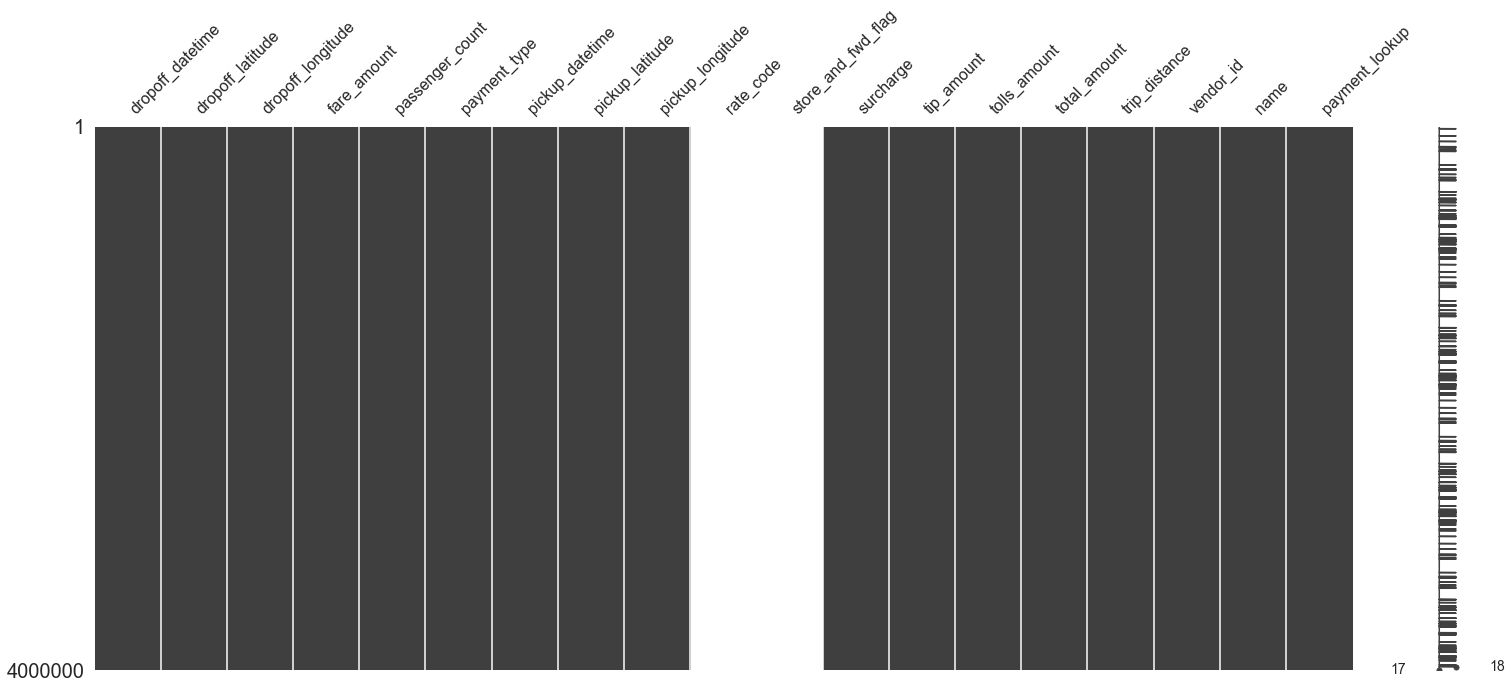

In [12]:
msno.matrix(df);

As shown in the figure, there's only two columns that have a lot of missing values (rate_code and store_and_fwd_flag). As they won't affect our analysis we will just drop them and do some consistency check to see if there's any missing values we didn't see in the figure.

In [12]:
df.drop(columns=['rate_code', 'store_and_fwd_flag'], inplace=True)

In [13]:
df.isna().sum()

dropoff_datetime     0
dropoff_latitude     0
dropoff_longitude    0
fare_amount          0
passenger_count      0
payment_type         0
pickup_datetime      0
pickup_latitude      0
pickup_longitude     0
surcharge            0
tip_amount           0
tolls_amount         0
total_amount         0
trip_distance        0
vendor_id            0
name                 0
payment_lookup       0
dtype: int64

### Feature Engineering - Date Features

We know that we don't have any more missing values. Now we will create some new features based on the pickup and dropoff datetime and locations to perform analysis. We will create features: the time elapsed and the average speed. Those features will be used to visualization and check abnormal values. 

Using the Google Maps, we could check that the *trip_distance* feature is in miles. [Path of first example of the dataset](https://www.google.com.br/maps/dir/40.74295,+-74.004114/40.74795,+-73.994712/@40.7457116,-74.0037917,16z/data=!3m1!4b1!4m10!4m9!1m3!2m2!1d-74.004114!2d40.74295!1m3!2m2!1d-73.994712!2d40.74795!3e2)

In [14]:
df['elapsed_time_hours'] = df.apply(lambda x: (x.dropoff_datetime-x.pickup_datetime).total_seconds()/3600, axis=1)
df['speed_miles_per_h'] = df['trip_distance']/df['elapsed_time_hours']

### Abnormal values

Now we can filter some abnormal values that can be contained on the dataset. Some of the features we will look at:

- trip_distance
- elapsed_time_hours
- speed_miles_per_h
- dropoff_latitude
- dropoff_longitude
- passenger_count
- pickup_latitude
- pickup_longitude
- total_amount

The first thing we can observe is some basic statistics from those features and see if we can find any abnormal value.

In [15]:
df[['trip_distance', 'elapsed_time_hours', 'speed_miles_per_h', 'dropoff_latitude', 'dropoff_longitude', 
    'passenger_count', 'pickup_latitude', 'pickup_longitude', 'total_amount']].describe()

,trip_distance,elapsed_time_hours,speed_miles_per_h,dropoff_latitude,dropoff_longitude,passenger_count,pickup_latitude,pickup_longitude,total_amount
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.678209e+00,1.457988e-01,2.021920e+01,4.013500e+01,-7.284804e+01,1.733573e+00,4.012473e+01,-7.283060e+01,1.032687e+01
std,3.130601e+00,4.059804e-02,2.630099e+01,4.986513e+00,9.050543e+00,1.254536e+00,5.026362e+00,9.122395e+00,8.503208e+00
min,0.000000e+00,6.840799e-03,0.000000e+00,-1.520200e-02,-7.919139e+01,0.000000e+00,-9.262000e-03,-8.487835e+01,2.500000e+00
25%,1.000000e+00,1.172772e-01,6.789120e+00,4.073537e+01,-7.399067e+01,1.000000e+00,4.073639e+01,-7.399112e+01,5.700000e+00
50%,1.700000e+00,1.456205e-01,1.199488e+01,4.075449e+01,-7.397953e+01,1.000000e+00,4.075453e+01,-7.398111e+01,7.800000e+00
75%,3.000000e+00,1.742050e-01,2.246880e+01,4.076952e+01,-7.396339e+01,2.000000e+00,4.076844e+01,-7.396681e+01,1.140000e+01
max,4.992000e+01,2.920377e-01,1.548665e+03,4.793581e+01,8.668000e-03,6.000000e+00,4.792285e+01,4.023000e-03,2.300000e+02


In [16]:
df.passenger_count.value_counts()

1    2589416
2     729792
5     339892
3     207760
4     116812
6      15884
0        444
Name: passenger_count, dtype: int64

Analyzing those statistics we can find some intriguing points:

- Trips with 0 miles
- Trips with speed above 150 miles per hour
- Dropoff and pickup coordinates close to 0
- Trips with 0 passengers

For the 0 passengers we also observed that it only represents 444 examples, so we will drop that.

We will consider those abnormal values as errors of typing and will drop them from our dataset. Here are the filters we will consider:

- Since we are considering only the NYC, the latitude and longitude coordinates for NYC were get from Google Maps and are:
    - "min_lat": 40.491588
    - "max_lat": 40.908962
    - "min_lng": -74.263428
    - "max_lng": -73.686467
- Trips have to have a minimum distance of 0.00001 and a maximum speed of 40 miles per hour
- Trips have to have at leat 1 passenger

In [17]:
df = df[
        (df.dropoff_latitude >= 40.491588) & (df.dropoff_latitude <= 40.908962) &
        (df.pickup_latitude >= 40.491588) & (df.pickup_latitude <= 40.908962) &
        (df.dropoff_longitude >= -74.263428) & (df.dropoff_longitude <= -73.686467) &
        (df.pickup_longitude >= -74.263428) & (df.pickup_longitude <= -73.686467) &
        (df.trip_distance >= 0.00001) & (df.speed_miles_per_h <= 40) &
        (df.passenger_count > 0)
       ]

In [18]:
df.shape

(3450958, 19)

After filtering we stay with $86.3\%$ of the original data and now the data is more reliable and we can study and have some visualizations to understand the behaviour of the data and get insights about the NYC taxi trips.

### Map of pickup and dropoff locations

Let's start plotting the pickup and dropoff locations from 2010 in a map view to check if there's any concentration of points.

For that we opted to not use any external library, so the steps to make the plot are the following

- First, get the image on [openstreetmap.org](https://www.openstreetmap.org/export#map=5/51.500/-0.100)
- Then plot the image and the points
- Set the bounding boxes of the image to the latitude and longitude limits

In [20]:
map_image = plt.imread('map.png')

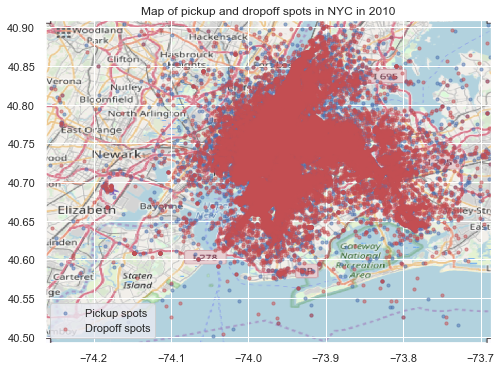

In [21]:
BBox = (-74.263428, -73.686467,      
         40.491588, 40.908962)
        
fig, ax = plt.subplots(figsize = (8,8));
ax.scatter(df[df.pickup_datetime.dt.year == 2010].pickup_longitude, df[df.pickup_datetime.dt.year == 2010].pickup_latitude, zorder=1, alpha= 0.5, c='b', s=10, label="Pickup spots");
ax.scatter(df[df.pickup_datetime.dt.year == 2010].dropoff_longitude, df[df.pickup_datetime.dt.year == 2010].dropoff_latitude, zorder=1, alpha= 0.5, c='r', s=10, label="Dropoff spots");
ax.set_title('Map of pickup and dropoff spots in NYC in 2010');
ax.set_xlim(BBox[0],BBox[1]);
ax.set_ylim(BBox[2],BBox[3]);
ax.imshow(map_image, zorder=0, extent = BBox, aspect= 'equal');
ax.legend();

As we can see in the map, there's some inconsistent spots in the ocean. Probably, that's due the inaccurate GPS location and as it's very close to the NYC we will consider them. We can also observe that the trips are all over the city.

### Number of trips

Now, we will draw some plots to observe the number of trips over the last three months of the years to observe if there's any peak due to the holidays and to observe if the number of trips had increased over the years.

In [22]:
df_plot = df[(df.pickup_datetime.dt.month >= 10)].copy()
df_plot = df_plot[['dropoff_datetime', 'pickup_datetime']].set_index('pickup_datetime').groupby(pd.Grouper(freq='D')).count().reset_index()
df_plot['year'] = df_plot.pickup_datetime.dt.year
df_plot['date'] = pd.to_datetime(df_plot.pickup_datetime.dt.strftime('%m-%d')+'-2000')
df_plot.columns = ['pickup_datetime', 'count', 'year', 'date']

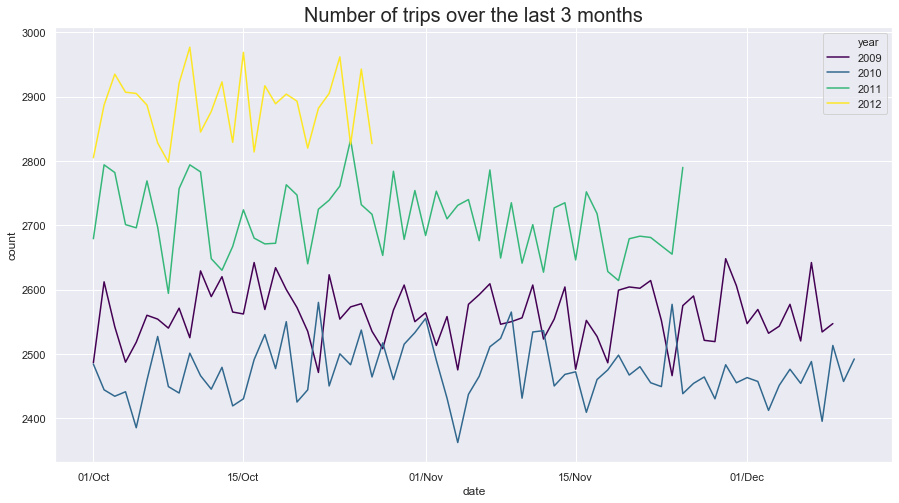

In [23]:
sns.lineplot(x="date", y="count", palette='viridis', hue = 'year', data=df_plot[df_plot['count'] > 0].sort_values('date'));
# get current axis
ax = plt.gca()
# convert all xtick labels to selected format from ms timestamp
ax.set_xticklabels(['01/Oct', '15/Oct', '01/Nov', '15/Nov', '01/Dec']);
ax.set_title('Number of trips over the last 3 months', fontsize = 20);

We can observe that only 2009 and 2010 has data for december and they have only until the 15th day, so we don't have enough data to conclude if there's any change in the number of trips because of the holidays. Besides that we can conclude that the number of trips has increased over the years with 300ish more trips per day.

### Average distance traveled by number of passengers

Now let's see if there's any difference between the average distance of trips with at least 2 passengers and 3 or more. 

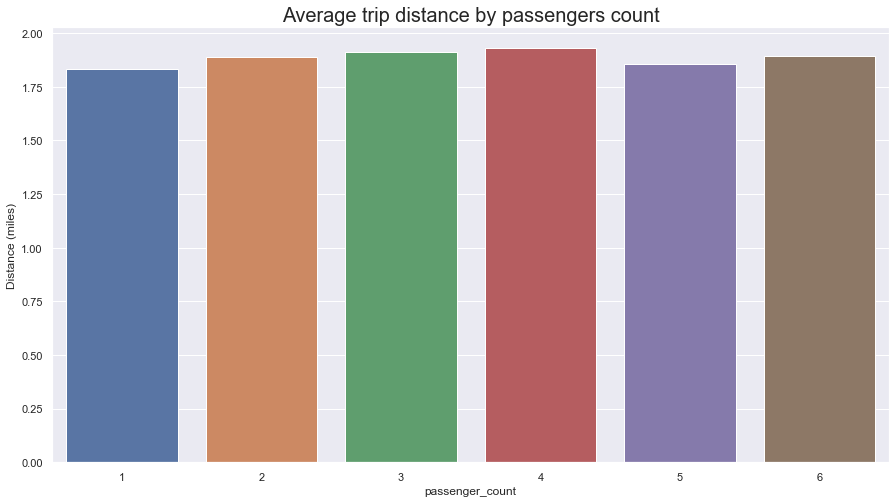

In [36]:
df_plot = df[['trip_distance', 'passenger_count']].groupby(by=['passenger_count']).mean().reset_index()
sns.barplot(x="passenger_count", y="trip_distance", data=df_plot);

ax = plt.gca()
ax.set_title('Average trip distance by passengers count', fontsize = 20);
ax.set_ylabel('Distance (miles)');

In [26]:
print("Average distance of trips with a maximum of 2 passengers:", df[df.passenger_count <= 2]['trip_distance'].mean())
print("Average distance of trips with a minimum of 3 passengers:", df[df.passenger_count > 2]['trip_distance'].mean())

Average distance of trips with a maximum of 2 passengers: 1.8442819588761425
Average distance of trips with a minimum of 3 passengers: 1.8870256224112107


As shown above, there's no significant difference between the distance traveled by different number of passengers.

### Biggest vendor

Next insight we want to generate is wich are the biggest vendors based on the total amount of money they raised over the year.

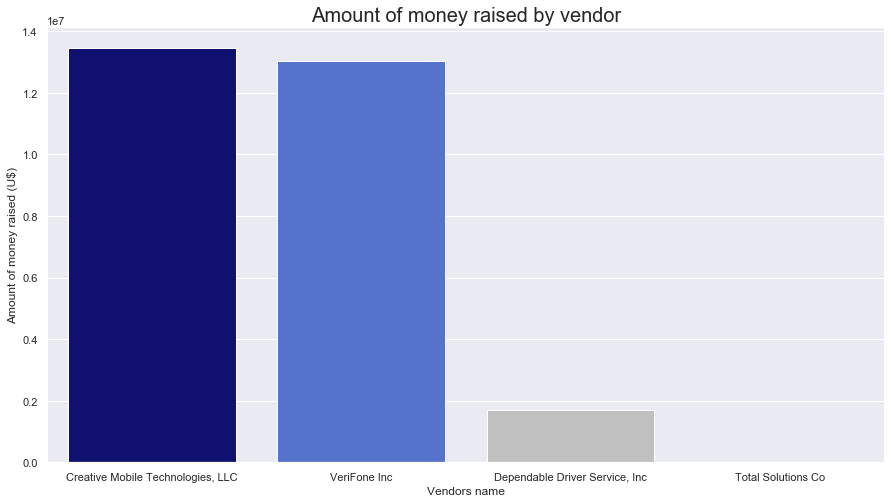

In [34]:
df_plot = df[['total_amount', 'name']].groupby(by=['name']).sum().reset_index()
sns.barplot(x="name", y="total_amount", data=df_plot.sort_values('total_amount', ascending=False), palette=['navy', 'royalblue', 'silver', 'silver']);

ax = plt.gca()
ax.set_title('Amount of money raised by vendor', fontsize = 20);
ax.set_ylabel('Amount of money raised (U$)');
ax.set_xlabel('Vendors name');

So, Creative Mobile Technologies and VeriFone had raised way much more money than the others vendors, with Dependable Driver Service being the third with only $12\%$ of the money raised if compared with the top 2.